In [1]:
# declare the imports for building our neural network and displaying our data 
import tensorflow as tf
import PIL
import os
import h5py
import sys
import numpy as np
import pandas as pd
import random
import csv
import cv2
import fnmatch
import kerastuner as kt
import matplotlib.pyplot as plt 
from shutil import copyfile
from sklearn.model_selection import train_test_split
from numpy import asarray
from numpy import savetxt
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Activation, BatchNormalization
from keras.utils import np_utils
from matplotlib import image
from os import listdir
from sklearn.metrics import classification_report
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

# set the input and outpout Dirs
data_dir = 'C:\\Users\davie\Desktop\Final_Project\FYP\HCurve'
Output = 'C:\\Users\davie\Desktop\Final_Project\FYP\Processed_Data\\'

In [2]:
#load and examine the shape of the datat
X_train = np.load(Output+'xtrain32x32.npy')
Y_train = np.load(Output+'ytrain32x32.npy')
X_test = np.load(Output+'xtest32x32.npy')
Y_test = np.load(Output+'ytest32x32.npy')
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(9818, 32, 32, 3)
(3273, 32, 32, 3)
(9818,)
(3273,)


In [3]:
# building the input vector from the 256x256 pixels
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalizing the data to help with the training
X_train /= 255
X_test /= 255

In [4]:
# one-hot encoding using keras
n_classes = 23
class_names = ['ABDMJ', 'Agen', 'Allaple', 'Autoit', 'Berbew', 'Bitman', 'Dinwod', 'Dorkbot', 
               'Dridex', 'Emotet', 'Fsysna', 'Hematite', 'InstallMonster', 'Oberal', 'Picsys', 
               'Salgorea', 'Scar', 'Sfone', 'Shifu', 'Socks', 'Sytro', 'Vilsel', 'Vobfus']
print("Shape before one-hot encoding: ", Y_train.shape)
Y_train = np_utils.to_categorical(Y_train, n_classes)
Y_test = np_utils.to_categorical(Y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (9818,)
Shape after one-hot encoding:  (9818, 23)


In [5]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(9818, 32, 32, 3)
(3273, 32, 32, 3)
(9818, 23)
(3273, 23)


In [6]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    for i in range(hp.Int("num_layers", 2, 20)):
        model.add(layers.Dense(units=hp.Int("units_" + str(i), min_value=32, max_value=512, step=32),activation="relu",))
    model.add(layers.Dense(23, activation="softmax"))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])),
                  loss="categorical_crossentropy",metrics=["accuracy"],)
    return model

In [7]:
# initialize an early stopping callback to prevent the model from
# overfitting/spending too much time training with minimal gains
es = EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)

In [8]:
tuner = kt.BayesianOptimization(build_model, objective="val_accuracy", max_trials=10, 
                                seed=42,directory=Output,project_name='AutoTuneBaysOPT')

In [9]:
# perform the hyperparameter search
print("[INFO] performing hyperparameter search...")
tuner.search(x=X_train, y=Y_train,validation_data=(X_test, Y_test), batch_size=100, callbacks=[es], epochs=30)
# grab the best hyperparameters
bestHP = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 10 Complete [00h 01m 25s]
val_accuracy: 0.8869538903236389

Best val_accuracy So Far: 0.9517262578010559
Total elapsed time: 01h 13m 14s
INFO:tensorflow:Oracle triggered exit


In [10]:
# build the best model and train it
print("[INFO] training the best model...")
model = tuner.hypermodel.build(bestHP)
history = model.fit(x=X_train, y=Y_train, validation_data=(X_test, Y_test), batch_size=100,epochs=30, callbacks=[es], verbose=1)
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(x=X_test, batch_size=100)
print(classification_report(Y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=class_names))

[INFO] training the best model...
Epoch 1/30
99/99 [==============================] - 13s 110ms/step - loss: 2.4801 - accuracy: 0.2831 - val_loss: 2.0314 - val_accuracy: 0.3645
Epoch 2/30
99/99 [==============================] - 15s 149ms/step - loss: 1.6856 - accuracy: 0.5102 - val_loss: 1.4790 - val_accuracy: 0.5518
Epoch 3/30
99/99 [==============================] - 16s 158ms/step - loss: 1.2235 - accuracy: 0.6479 - val_loss: 1.0795 - val_accuracy: 0.6832
Epoch 4/30
99/99 [==============================] - 20s 207ms/step - loss: 0.9545 - accuracy: 0.7281 - val_loss: 0.9035 - val_accuracy: 0.7351
Epoch 5/30
99/99 [==============================] - 20s 202ms/step - loss: 0.7868 - accuracy: 0.7832 - val_loss: 0.7661 - val_accuracy: 0.7987
Epoch 6/30
99/99 [==============================] - 21s 214ms/step - loss: 0.6653 - accuracy: 0.8176 - val_loss: 0.8149 - val_accuracy: 0.7705
Epoch 7/30
99/99 [==============================] - 20s 207ms/step - loss: 0.5667 - accuracy: 0.8480 - val_l

In [11]:
# evaluate the model and print the score to screen 
trainingscores = model.evaluate(X_train, Y_train, verbose=0)
testingscores = model.evaluate(X_test, Y_test, verbose=0)
print("[INFO] evaluating network")
predictions = model.predict(X_test, batch_size=100)
print("training scores are below \n")
print("%s: %.2f%%" % (model.metrics_names[1], trainingscores[1]*100))
print("testing scores are below \n")
print("%s: %.2f%%" % (model.metrics_names[1], testingscores[1]*100))

[INFO] evaluating network
training scores are below 

accuracy: 92.54%
testing scores are below 

accuracy: 88.60%


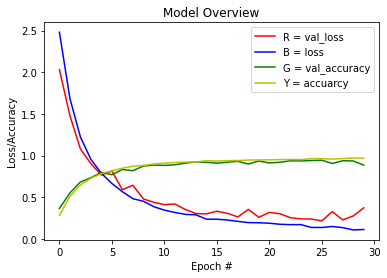

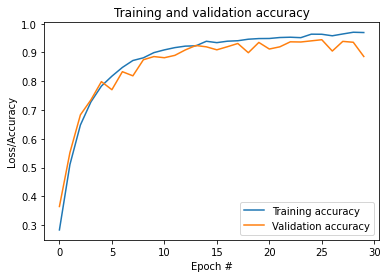

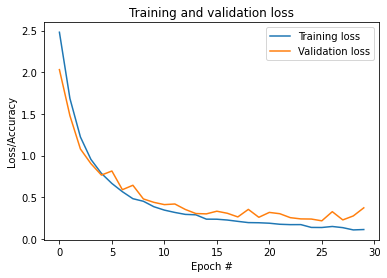

In [12]:
# Declare vars for the plotting of figures 
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

# overall model scoreing 
plt.plot(val_loss, 'r', loss, 'b', val_accuracy, 'g', accuracy, 'y')
label = 'R = val_loss', 'B = loss', 'G = val_accuracy', 'Y = accuarcy'
plt.title('Model Overview')
plt.legend(label)
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.show()

# Training output 
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.show()

# testing output 
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.show()

In [13]:
model.save(Output + "autotuneBaysOpt.h5")
print("Saved model to disk")

Saved model to disk
